### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

In [3]:
batch_size = 100
noise_std = 0.01
n_epochs = 500

### Loading MNIST Data Set

In [4]:
n_train, n_test = 1000, 1000

train_indices = sorted(np.random.choice(60000, n_train))
test_indices = sorted(np.random.choice(10000, n_test))

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           target_transform=transforms.Lambda(
                                              lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          target_transform=transforms.Lambda(
                                              lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(train_dataset, train_indices), 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(test_dataset, test_indices),
                                          batch_size=1, 
                                          shuffle=False)


### Example Images

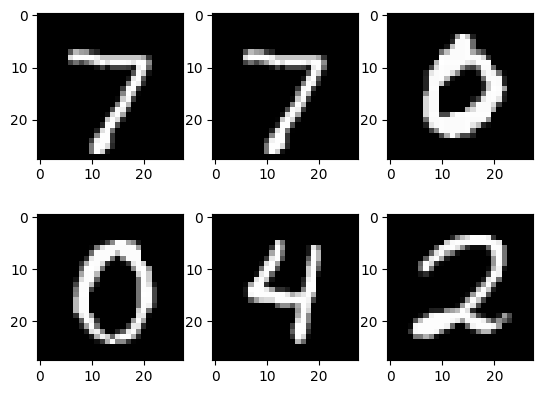

In [37]:
examples = iter(test_loader)

if batch_size < 6:

    for i in range(6):
        example_data, example_targets = next(examples)
        plt.subplot(2,3,i+1)
        plt.imshow(example_data[0][0], cmap='gray')
    plt.show()

else:
    for i in range(6):
        example_data, example_targets = next(examples)
        plt.subplot(2,3,i+1)
        plt.imshow(example_data[0][0], cmap='gray')
    plt.show()



### Define Classes for i) layers and ii) a full model

In [ ]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.zeros(output_dim)

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).




class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_covar = torch.eye(output_dim)*noise_std

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)

        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""

        ll_tensor = torch.tensor(0)
        for i, y in enumerate(y_pred.squeeze(0)):
            l = torch.distributions.multivariate_normal.MultivariateNormal(y, self.noise_covar)
            ll_tensor = ll_tensor + l.log_prob(y_obs[i].repeat(num_samples,1,1)).mean(0)
        
        return ll_tensor.squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl
    

bnn_model = MeanFieldBNN(28*28, [20,20], 10, noise_std=noise_std)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
  )
)


In [ ]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(n_epochs)): 
    for i, (tr_images, tr_labels) in enumerate(train_loader):  # iterate over each batch
            
        tr_images = tr_images.reshape(-1, 28*28).to(device)  # [batch_size, 1, 28, 28] to [batch_size, 28*28]
        tr_labels = tr_labels.to(device)

        opt.zero_grad()
        l, ll, kl = bnn_model.loss(tr_images, tr_labels)

        l.backward()
        opt.step()

    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(tr_images), tr_labels.unsqueeze(0)).item())

    # te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    # te_mse_loss_evo.append(aux_loss(bnn_model(x_te), y_te.unsqueeze(0)).item())



100%|██████████| 500/500 [1:23:22<00:00, 10.00s/it]      


### Plot Evolution of Various Metrics

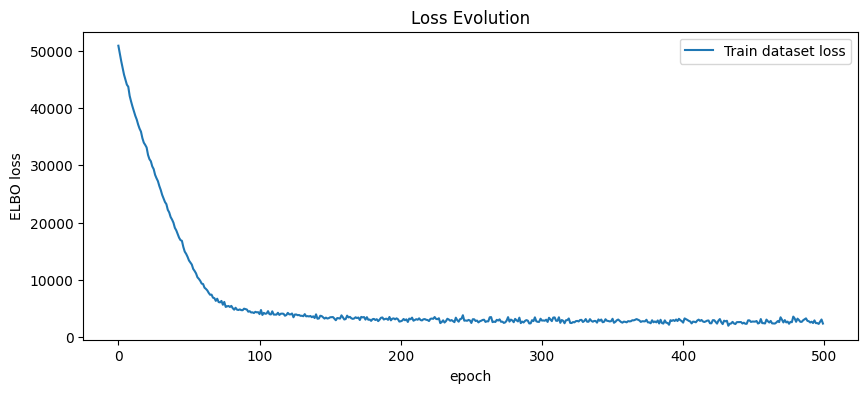

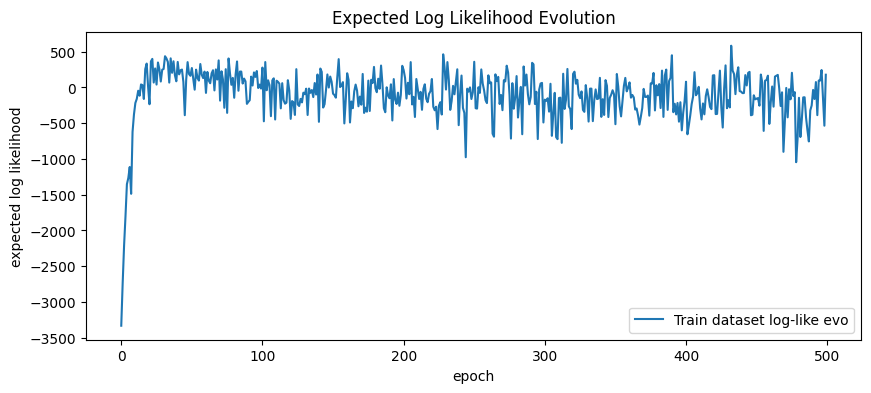

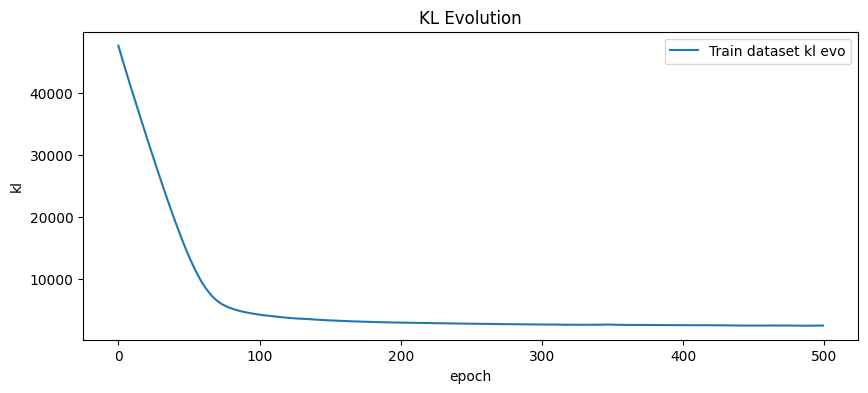

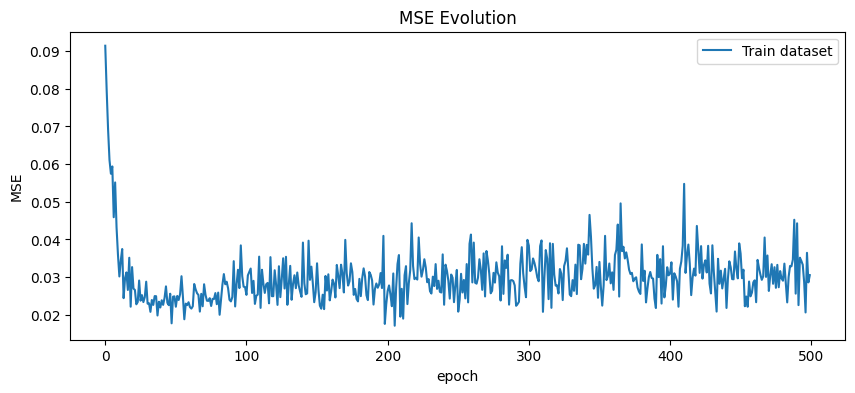

In [ ]:
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
# plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
# plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

### Testing Accuracy

In [ ]:
with torch.no_grad():

    n_correct = 0
    for images, labels in test_loader:

        images = images.reshape(-1, 28*28).to(device)
        _, labels = torch.max(labels, 1)

        outputs = bnn_model(images).squeeze(0)
        _, pred = torch.max(outputs, 1)

        n_correct += (pred == labels).sum().item()
    
    print(f'Accuracy on {n_test} test images: {n_correct / n_test * 100:.1f}%')

Accuracy on 1000 test images: 80.6%


### Testing Confidence on a Single Image

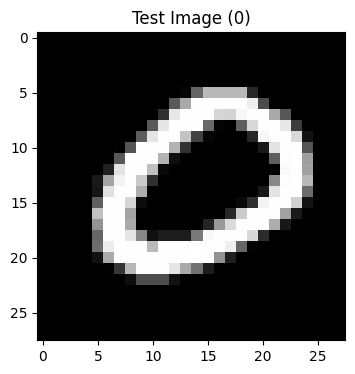

Accuracy for this image is 97.8% 
Confidence is 84.3


In [ ]:
with torch.no_grad():

    test_image, test_label = test_dataset[np.random.randint(len(test_dataset))]
    _, test_label = torch.max(test_label, 0)

    plt.imshow(test_image[0], cmap='gray')
    plt.title(f'Test Image ({test_label})')
    plt.show()

    test_image = test_image.reshape(-1, 28*28).to(device)

    n_samples = 500
    outputs = bnn_model(test_image, num_samples=n_samples).squeeze(1)
    _, pred = torch.max(outputs, 1)

    confidence = torch.mean(outputs, 0)[test_label]

    n_correct = sum([1 for pred_i in pred if pred_i == test_label.item()])
    print(f'Accuracy for this image is {n_correct / n_samples * 100:.1f}% \nConfidence is {confidence*100:.1f}')

In [ ]:
counts = torch.bincount(pred, minlength=10)
relative_frequencies = counts.float() / pred.size(0)
relative_frequencies

tensor([0.9780, 0.0000, 0.0000, 0.0000, 0.0000, 0.0040, 0.0180, 0.0000, 0.0000,
        0.0000])

In [ ]:
pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0,
        0, 0, 0, 0])

In [ ]:
counts = torch.bincount(pred, minlength=10)
relative_frequencies = counts.float() / pred.size(0)
relative_frequencies

tensor([0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0100, 0.0100, 0.0000, 0.0000,
        0.0000])

In [ ]:
with torch.no_grad():

    n_samples = 500
    confidence_mat = torch.empty((n_test, 10))
    labels = torch.empty((n_test, 10))

    for i, (image, label) in enumerate(test_loader):
        
        test_image = image.reshape(-1, 28*28).to(device) # this line had test_image twice!

        outputs = bnn_model(test_image, num_samples=n_samples).squeeze(1)
        _, pred = torch.max(outputs, 1)
        counts = torch.bincount(pred, minlength=10)
        relative_frequencies = counts.float() / n_samples

        # confidence = torch.mean(outputs, 0)
        confidence_mat[i,] = relative_frequencies
        labels[i,] = label


confidence_mat = confidence_mat.flatten()
labels = labels.flatten()

data = torch.stack((confidence_mat, labels), 1)
data

tensor([[0.0080, 0.0000],
        [0.0000, 0.0000],
        [0.8660, 1.0000],
        ...,
        [0.0080, 0.0000],
        [0.7540, 1.0000],
        [0.0060, 0.0000]])

In [ ]:
df = pd.DataFrame(data.numpy(), columns=['confidence', 'true_label'])
df.to_csv('calibration_data.csv', index=False)

In [ ]:
df['confidence'].max()

1.0